# Data Analysis for Chicago traffic
1. Auto encoder
1. Long Short Term Memory

In [1]:
!pip install keras

  Using cached Keras-2.1.5-py2.py3-none-any.whl
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pwd

/content/datalab


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = [20, 8]

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%bq query -n speed_at_times
SELECT
  _last_updt, current_speed, _region_id
FROM
  `nickapi-184104.demos.regions`
WHERE
  _last_updt > "2018-04-03 12:00:00.000 UTC"

In [5]:
df = speed_at_times.execute().result().to_dataframe()

In [6]:
df.describe()

,current_speed,_region_id
count,21025.000000,21025.000000
mean,21.850574,15.000000
std,7.934416,8.366799
min,0.000000,1.000000
25%,19.770000,8.000000
50%,23.180000,15.000000
75%,26.590000,22.000000
max,173.860000,29.000000


In [7]:
df = df.drop_duplicates()
df = df.pivot(index='_last_updt', columns='_region_id', values='current_speed')
df = df.dropna(how='any')

In [8]:
df.describe()

_region_id,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,...,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,18.136066,24.751865,21.426630,18.157100,21.134075,20.433856,19.315110,19.277069,20.622179,21.636317,...,23.342743,21.598730,25.575063,21.679514,22.560078,23.956473,27.593448,27.070361,18.947759,18.271614
std,7.855046,7.755274,7.687187,6.969802,7.270006,5.344104,6.312675,5.804360,8.135894,3.353134,...,6.317289,7.731091,8.228458,2.909232,6.119551,11.423464,6.505279,8.347310,16.832715,9.094497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.090000,25.230000,19.090000,17.730000,20.450000,18.410000,17.730000,17.730000,21.140000,19.437500,...,22.500000,20.450000,26.197500,19.770000,21.140000,26.590000,24.550000,27.270000,0.000000,17.730000
50%,20.450000,26.590000,21.140000,19.090000,23.180000,21.140000,20.450000,19.090000,22.500000,21.140000,...,24.550000,23.860000,27.375000,21.140000,23.860000,28.640000,27.270000,28.670000,27.340000,20.450000
75%,21.820000,28.002500,23.860000,21.820000,25.230000,23.180000,22.500000,22.500000,24.105000,23.860000,...,25.910000,25.910000,29.320000,23.860000,25.282500,30.000000,30.000000,30.680000,33.112500,23.180000
max,34.090000,37.400000,173.860000,32.050000,32.450000,50.450000,34.470000,37.500000,35.390000,32.050000,...,68.900000,41.110000,40.400000,29.320000,35.450000,38.800000,54.550000,42.170000,52.740000,39.580000


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


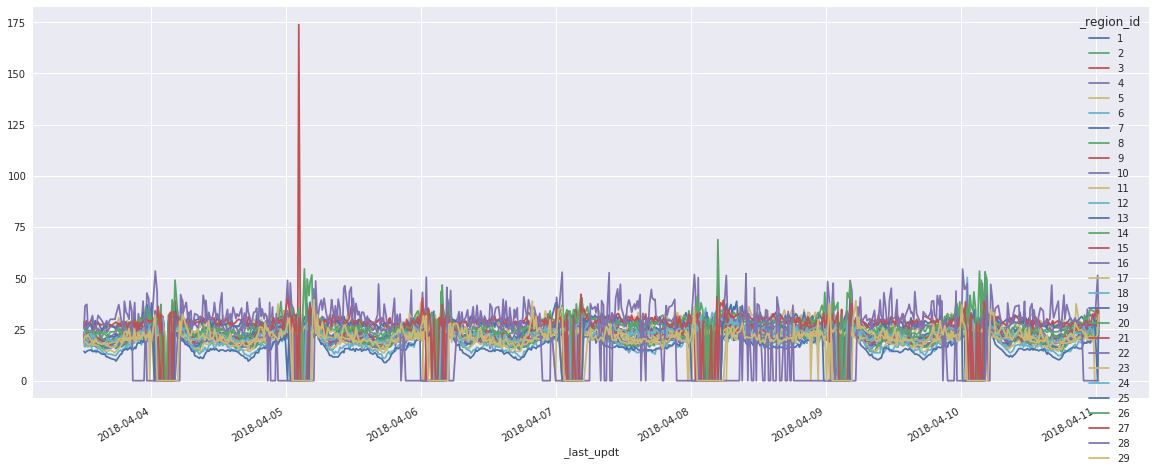

In [9]:
df.plot()

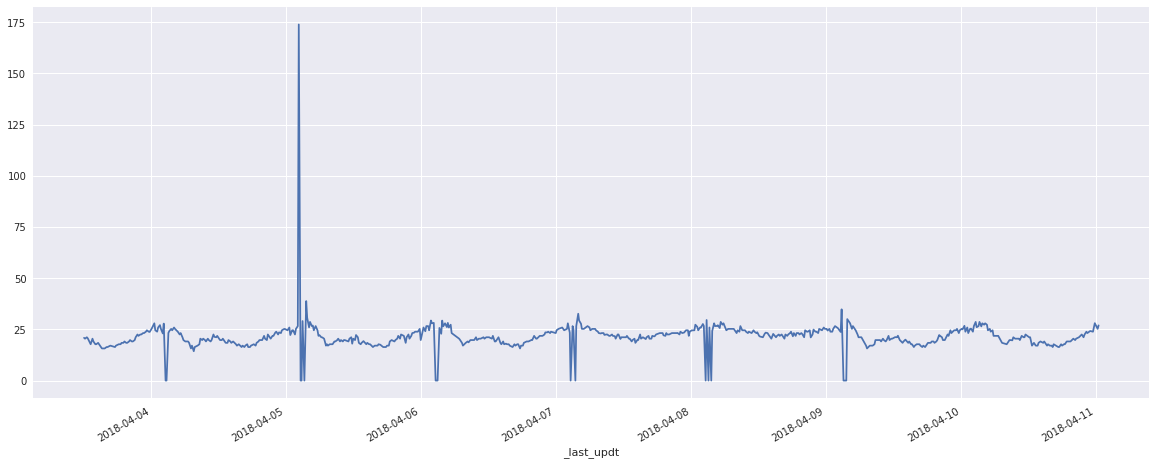

In [10]:
df[3].plot()

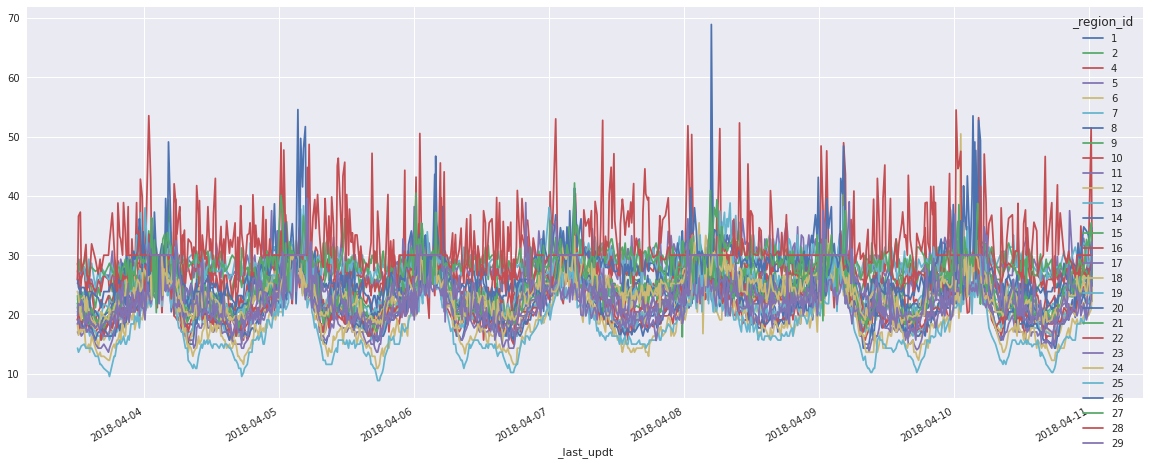

In [24]:
df.replace(0, 30).drop(3,1).plot()

# Auto Encoder Network
An autoencoder, autoassociator or Diabolo network is an artificial neural network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Recently, the autoencoder concept has become more widely used for learning generative models of data.

![AE](https://cdn-images-1.medium.com/max/800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

In [25]:
df = df.replace(0, 30)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [26]:
tf.reset_default_graph() 

In [27]:
num_inputs = 29
num_hidden = 2
num_outputs = num_inputs

learning_rate = 0.01

In [28]:
X = tf.placeholder(tf.float32, shape=[None, num_inputs])

In [29]:
hidden = fully_connected(X, num_hidden, activation_fn=None)
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

In [30]:
loss = tf.reduce_mean(tf.square(outputs - X))

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

In [32]:
init = tf.global_variables_initializer()

In [33]:
num_steps = 4000

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        sess.run(train,feed_dict={X: scaled_data})

In [34]:
with tf.Session() as sess:
    sess.run(init)
    output_2d = hidden.eval(feed_dict={X: scaled_data})

In [35]:
output_2d.shape

(638, 2)

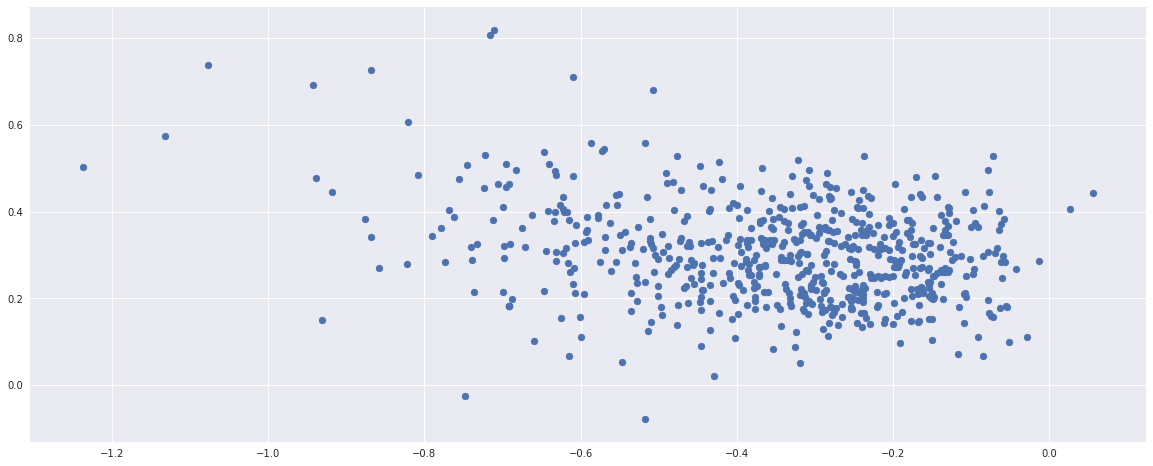

In [36]:
plt.scatter(output_2d[:,0],output_2d[:,1])

# Time Series Forecasting with Sliding Window
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![LSTM](https://cdn-images-1.medium.com/max/2000/1*Ka6k_WyG9B3gXPlvU0vrOw.png)

### Steps
1. Grab data from bigquery
2. Take speed data and create a global average
3. Format data for ingestion with sliding window
4. Define model
5. Train model
6. Test model

In [37]:
%bq query -n speed_at_times
SELECT
  _last_updt, current_speed, _region_id
FROM
  `nickapi-184104.demos.regions`
WHERE
  _last_updt > "2018-04-03 12:00:00.000 UTC"

In [38]:
df = speed_at_times.execute().result().to_dataframe()

In [39]:
df = df.drop_duplicates()
df = df.pivot(index='_last_updt', columns='_region_id', values='current_speed')
df = df.dropna(how='any')
df.head()

_region_id,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
_last_updt,,,,,,,,,,,,,,,,,,,,,
2018-04-03 12:10:42,19.09,28.50,20.86,19.09,21.14,20.45,19.09,18.41,21.82,19.09,...,20.45,23.18,27.27,18.41,23.86,27.14,25.91,28.64,25.91,19.77
2018-04-03 12:20:58,19.77,28.64,20.45,18.89,19.77,20.45,19.77,18.41,21.68,20.45,...,20.93,20.52,27.95,19.19,23.18,27.27,24.55,27.27,36.58,21.82
2018-04-03 12:40:29,19.77,27.27,21.14,17.05,20.45,20.45,19.09,18.41,22.50,19.09,...,23.86,23.18,25.23,18.41,19.77,27.27,23.86,29.32,37.26,21.55
2018-04-03 12:50:44,18.41,27.14,20.59,19.09,22.50,20.45,19.09,18.41,20.45,19.09,...,23.18,23.18,26.45,17.73,22.50,27.95,24.55,27.27,27.27,22.50
2018-04-03 13:21:04,19.09,27.95,17.73,17.05,19.09,19.77,19.09,17.73,21.14,19.09,...,22.50,19.09,27.27,17.73,23.18,27.95,24.55,28.64,29.18,19.84


In [40]:
df = df.replace(0,30)
df['mean'] = df.mean(axis=1)
df['mean'].to_frame().head(10)

,mean
_last_updt,
2018-04-03 12:10:42,22.011034
2018-04-03 12:20:58,22.463793
2018-04-03 12:40:29,22.131724
2018-04-03 12:50:44,21.943103
2018-04-03 13:21:04,21.780345
2018-04-03 13:40:31,21.338966
2018-04-03 13:50:45,21.207931
2018-04-03 14:10:48,21.282414
2018-04-03 14:21:04,20.569655


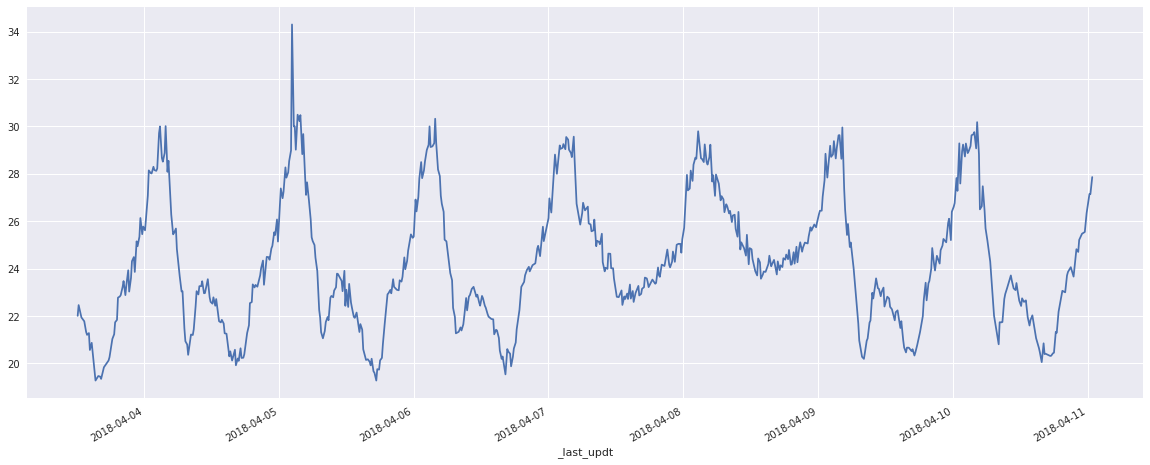

In [41]:
df['mean'].plot()

In [42]:
split_date = '2018-04-08 00:00:00'
train = df.loc[:split_date, ['mean']]
test = df.loc[split_date:, ['mean']]

In [43]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

train_sc.shape

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
_last_updt,
2018-04-03 12:10:42,0.181822
2018-04-03 12:20:58,0.211965
2018-04-03 12:40:29,0.189857
2018-04-03 12:50:44,0.177300
2018-04-03 13:21:04,0.166464


In [44]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
_last_updt,,,,,,,,,,,,
2018-04-03 16:10:58,0.012695,0.000046,0.105971,0.085861,0.133313,0.128355,0.137078,0.166464,0.177300,0.189857,0.211965,0.181822
2018-04-03 16:21:18,0.011088,0.012695,0.000046,0.105971,0.085861,0.133313,0.128355,0.137078,0.166464,0.177300,0.189857,0.211965
2018-04-03 16:51:00,0.004683,0.011088,0.012695,0.000046,0.105971,0.085861,0.133313,0.128355,0.137078,0.166464,0.177300,0.189857
2018-04-03 17:40:43,0.037306,0.004683,0.011088,0.012695,0.000046,0.105971,0.085861,0.133313,0.128355,0.137078,0.166464,0.177300
2018-04-03 17:50:57,0.056314,0.037306,0.004683,0.011088,0.012695,0.000046,0.105971,0.085861,0.133313,0.128355,0.137078,0.166464


In [45]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

X_train_t.shape

(373, 1, 12)

In [46]:
# import pickle
# import numpy as np

# speeds = (X_train_t, y_train)

# pickling_on = open("speeds.pickle","wb")

# pickle.dump(speeds, pickling_on)

# pickling_on.close()

# pickle_off = open("speeds.pickle","rb")
# (a,b) = pickle.load(pickle_off)
# if np.array_equal(a, X_train_t):
#   print "Perfect!"
# else:
#   print "It didn't work"

In [47]:
# !gsutil cp speeds.pickle gs://mysb

In [48]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=0)

In [50]:
score = model.evaluate(X_test_t, y_test, verbose=0)
print "Loss is {}%".format(score)

Loss is 0.00208164919274%


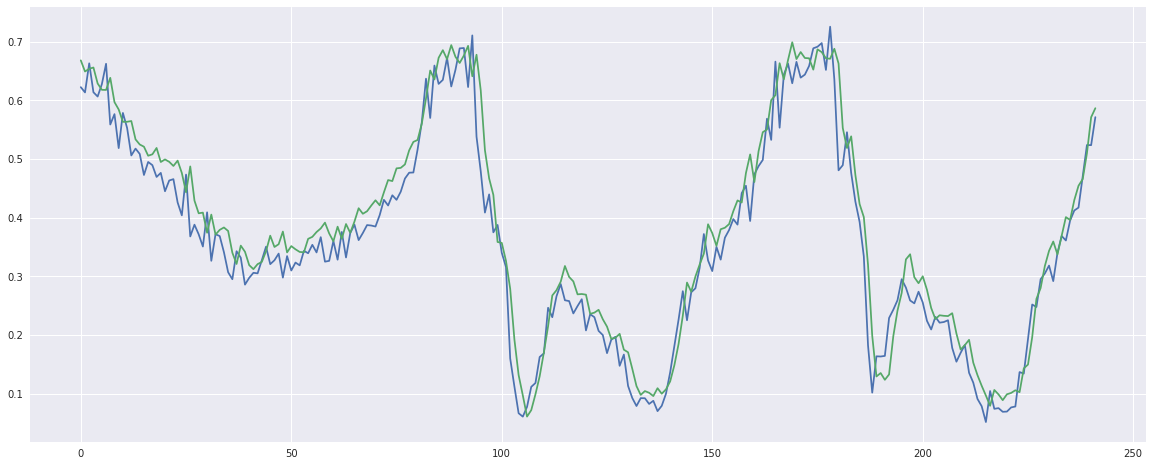

In [51]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [27]:
# save model and test if saved sucessfully
# model_json = model.to_json()
# model_filename = "trafficforecastmodel.json"
# weights_filename = "trafficforecastweights.h5"
# with open(model_filename, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(weights_filename)

# from keras.models import model_from_json

# json_file = open(model_filename, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# potato = model_from_json(loaded_model_json)
# # load weights into new model
# potato.load_weights(weights_filename)

# y_pred = potato.predict(X_test_t)
# plt.plot(y_test)
# plt.plot(y_pred)

# Cloud ML to train

![cloudml](https://www.ocadotechnology.com/uploads/tensorflow.png)

* Train: https://cloud.google.com/ml-engine/docs/tensorflow/training-steps
* Deploy: https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models

In [82]:
%%bash
gcloud ml-engine jobs submit training testtraffic5\
    --job-dir gs://mysb/traffic_chicago$(date +%Y%m%d_%H%M%S) \
    --runtime-version 1.0 \
    --module-name trainer.test \
    --package-path ./trainer \
    --region us-east1 \
    -- \
    --train-file gs://mysb/speeds.pickle

jobId: testtraffic5
state: QUEUED


/tools/google-cloud-sdk/lib/googlecloudsdk/core/util/files.py:622: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  for chunk in iter(lambda: fp.read(4096), ''):
Job [testtraffic5] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe testtraffic5

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs testtraffic5
